# Profiling and Analysis Questions


Clustering
https://web.ist.utl.pt/rmch/dash/guides/Clustering%20in%20Python.html


- what are the top aisle purchase clusters?
- what are the most common timeframe order time clusters (order_dow, order_hour_of_day,days_since_prior_order and weeks_since_prior_order) ?

PCA Resources
- https://www.kaggle.com/code/asindico/customer-segments-with-pca
- https://www.datacamp.com/tutorial/principal-component-analysis-in-python
- https://www.youtube.com/watch?v=8klqIM9UvAc
- https://www.youtube.com/watch?v=FD4DeN81ODY
- https://www.youtube.com/watch?v=HMOI_lkzW08


# NOTAS PROF
- DETETAR E EXCLUIR OUTLIERS DOS CLUSTERS PEQUENOS 
- ADICIONAR DENDROGRAMA DOS CLUSTERS
- EXPERIMENTAR DBSCAN
- ADICIONAR E VALIDAR CENTROIDES

# File and libraries

In [839]:
import pandas as pd
import numpy as np


filepath=r'/Users/cozmaeug/Private/IST PG - DS/DaSH ENG/ist_dash_2024_rec/non_supervised_analysis/notebooks/dataset_2/df_bakery_encoded.csv'

file_tag = "Bakery Clustering"

data = pd.read_csv(filepath)


In [840]:
%run "scripts/dslabs_functions.py"

In [841]:
%run "scripts/data_functions.py"

data_functions lodaded


In [842]:
from pandas import Series, to_numeric, to_datetime

id_cols=['order_id', 'product_id', 'user_id','aisle_id','department_id']

# data=data.drop(columns=id_cols, axis=1)


def get_variable_types(df: DataFrame) -> dict[str, list]:
    variable_types: dict = {"numeric": [], "binary": [], "date": [], "symbolic": [], "id": []}

    nr_values: Series = df.nunique(axis=0, dropna=True)
    for c in df.columns:
        if 2 == nr_values[c]:
            variable_types["binary"].append(c)
            df[c].astype("bool")
        else:
            try:
                to_numeric(df[c], errors="raise")
                variable_types["numeric"].append(c)
            except ValueError:
                try:
                    df[c] = to_datetime(df[c], errors="raise")
                    variable_types["date"].append(c)
                except ValueError:
                    variable_types["symbolic"].append(c)

    return variable_types


variable_types: dict[str, list] = get_variable_types(data)
print(variable_types)


{'numeric': ['total', 'angbutter', 'plain bread', 'jam', 'americano', 'croissant', 'caffe latte', 'tiramisu croissant', 'cacao deep', 'pain au chocolat', 'almond croissant', 'croque monsieur', 'mad garlic', 'milk tea', 'gateau chocolat', 'pandoro', 'cheese cake', 'lemon ade', 'orange pound', 'wiener', 'vanila latte', 'berry ade', 'merinque cookies', 'day_of_year', 'season', 'Purchase value', 'product_category', 'time_of_day_sin', 'time_of_day_cos', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos', 'min_sin', 'min_cos', 'day_of_month_sin', 'day_of_month_cos', 'day_of_week_nr_sin', 'day_of_week_nr_cos', 'week_of_month_sin', 'week_of_month_cos'], 'binary': ['tiramisu', 'is_weekend', 'address_강남동', 'address_교동', 'address_교동 ', 'address_근화동', 'address_동내면', 'address_동면', 'address_석사동', 'address_소양동', 'address_신동면', 'address_신사우동', 'address_약사명동', 'address_조운동', 'address_퇴계동', 'address_효자 1동', 'address_효자 2동', 'address_효자 3동', 'address_후평 1동', 'address_후평 2동', 'address_후평 3동'], 'date': [], '

# Data processing

## Missing Values

### Filling MV with median
For K-means clustering, it's particularly important to avoid outliers or large deviations caused by extreme values, so median might be a safer choice than the mean.

In [843]:
data['total'] = data['total'].fillna(data['total'].median())
data['Purchase value'] = data['Purchase value'].fillna(data['Purchase value'].median())



### Drop MV

In [844]:
data=data.copy()
data = data.dropna(axis=0, how="any") #axis=0 tells dropna to remove rows that have at least one NaN value.
print(data.shape)

(2421, 62)


## Outliers
Why Might Truncating Outliers Hurt Your Clustering?
- Distortion of Data Distribution
    - Truncation reduces variance by capping extreme values, which might make clusters less distinct.
    - If real outliers hold meaningful patterns (e.g., high-spending customers), removing or capping them can cause loss of valuable information.
-------------------------------------------------
- Agglomerative Clustering Is More Sensitive to Outliers
    - Hierarchical clustering does not use centroids, meaning it relies heavily on pairwise distances.
    - If outliers are truncated and brought closer to the mean, it compresses distances, making it harder to separate clusters.
    - In contrast, K-Means can still adjust since it recalculates centroids iteratively.
- K Means Might Not Be Affected as Much
    - K-Means assumes spherical clusters and is somewhat robust to outliers.
However, truncation can reduce variation, making cluster centers less meaningful.
If real outliers represent unique customer behaviors, K-Means might struggle to differentiate them after truncation.

In [845]:
# Remove extreme outlier in "total" column
data = data[data["total"] <= 90000.0]
data.head()
print(data.shape)

(2418, 62)


## Drop irrelevant variables

In [846]:
from sklearn.feature_selection import VarianceThreshold

# Remove features with very low variance
selector = VarianceThreshold(threshold=0.1)  # Ajuste o threshold conforme necessário
X_reduced = selector.fit_transform(data)

# Get selected features
selected_features = data.columns[selector.get_support()]
print(selected_features)

Index(['total', 'angbutter', 'plain bread', 'jam', 'americano', 'croissant',
       'caffe latte', 'tiramisu croissant', 'cacao deep', 'pain au chocolat',
       'almond croissant', 'pandoro', 'orange pound', 'wiener', 'vanila latte',
       'day_of_year', 'is_weekend', 'season', 'Purchase value',
       'product_category', 'address_동면', 'time_of_day_sin', 'time_of_day_cos',
       'month_sin', 'month_cos', 'hour_sin', 'min_sin', 'min_cos',
       'day_of_month_sin', 'day_of_month_cos', 'day_of_week_nr_sin',
       'day_of_week_nr_cos', 'week_of_month_sin', 'week_of_month_cos'],
      dtype='object')


In [847]:
import pandas as pd
from sklearn.feature_selection import VarianceThreshold


# Print initial features
print("Initial features:\n", data.columns.tolist())

# Compute variance for each feature
feature_variance = data.var()
print("\nFeature Variance:\n", feature_variance)

# Define threshold (adjust based on the dataset)
threshold = 0.1
selector = VarianceThreshold(threshold=threshold)

# Fit and transform the dataset
X_reduced = selector.fit_transform(data)

# Get selected features
initial_features = list(set(data.columns))
removed_features = list(set(data.columns) - set(selected_features))
selected_features = data.columns[selector.get_support()]


# Print results
print("Initial Features df_prep:\n", initial_features)
print("\nRemoved Features (low variance < {:.3f}):\n".format(threshold), removed_features)
print("\nFinal Features list:\n", selected_features.tolist())


Initial features:
 ['total', 'angbutter', 'plain bread', 'jam', 'americano', 'croissant', 'caffe latte', 'tiramisu croissant', 'cacao deep', 'pain au chocolat', 'almond croissant', 'croque monsieur', 'mad garlic', 'milk tea', 'gateau chocolat', 'pandoro', 'cheese cake', 'lemon ade', 'orange pound', 'wiener', 'vanila latte', 'berry ade', 'tiramisu', 'merinque cookies', 'day_of_year', 'is_weekend', 'season', 'Purchase value', 'product_category', 'address_강남동', 'address_교동', 'address_교동 ', 'address_근화동', 'address_동내면', 'address_동면', 'address_석사동', 'address_소양동', 'address_신동면', 'address_신사우동', 'address_약사명동', 'address_조운동', 'address_퇴계동', 'address_효자 1동', 'address_효자 2동', 'address_효자 3동', 'address_후평 1동', 'address_후평 2동', 'address_후평 3동', 'time_of_day_sin', 'time_of_day_cos', 'month_sin', 'month_cos', 'hour_sin', 'hour_cos', 'min_sin', 'min_cos', 'day_of_month_sin', 'day_of_month_cos', 'day_of_week_nr_sin', 'day_of_week_nr_cos', 'week_of_month_sin', 'week_of_month_cos']

Feature Variance:


In [848]:
data = data[selected_features]

## Drop redundant variables
 - Correlation interpretation - values between [-1,1]:
      - 0.9 and above: Very strong correlation (typically, > 0.9 is considered almost perfect).
      - 0.7 to 0.9: Strong correlation.
      - 0.3 to 0.7: Moderate correlation.
      - 0.1 to 0.3: Weak correlation.
      - 0 to 0.1: No significant correlation.  

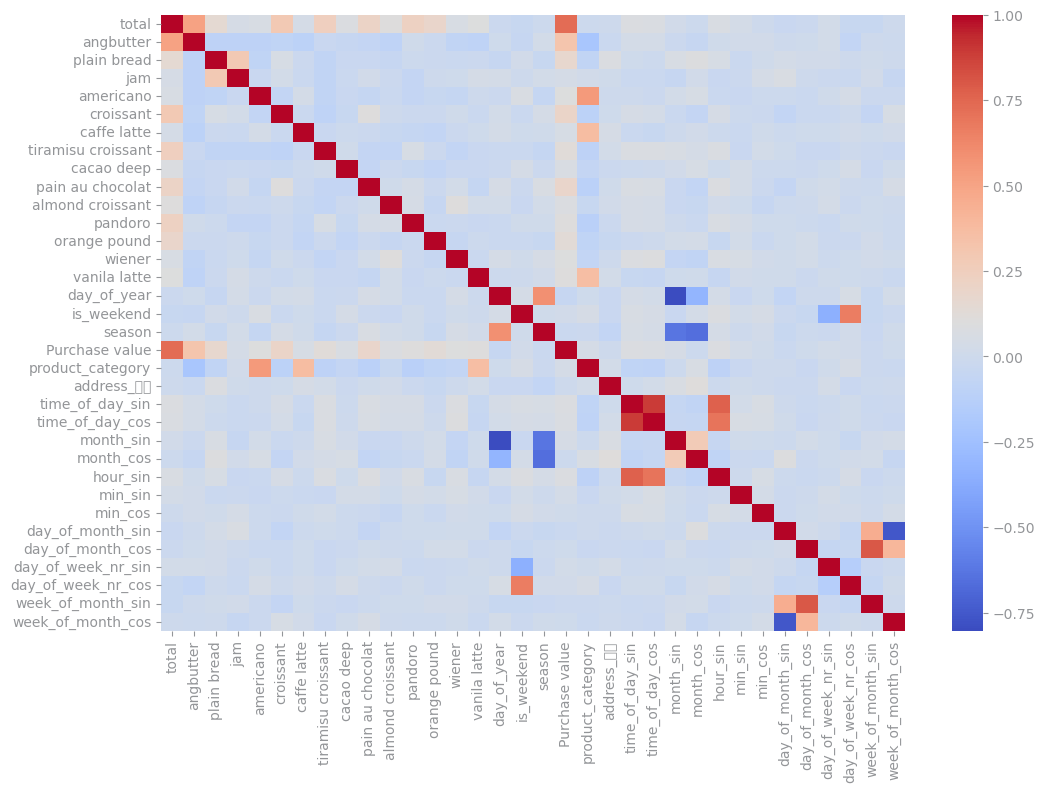

In [730]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = data.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.show()

In [731]:
import numpy as np

# Calculate correlation matrix
corr_matrix = data.corr()

# Identify pairs of highly correlated features (correlation > 0.8)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Initialize an empty list to store the pairs of highly correlated features
redundant_pairs = []

# Loop through each column to find pairs with correlation > 0.8
for column in upper_tri.columns:
    for row in upper_tri.index:
        if upper_tri.loc[row, column] > 0.7:
            redundant_pairs.append((row, column, upper_tri.loc[row, column]))

# Print initial features count
print(f"Initial number of features: {len(data.columns)}")

# Print redundant pairs
print(f"Redundant pairs (correlation > 0.7):")
for pair in redundant_pairs:
    print(f"{pair[0]} and {pair[1]}: Correlation = {pair[2]}")

# Identify the features to drop based on redundancy
to_drop = [pair[1] for pair in redundant_pairs]

# Print features that will be dropped
print(f"Number of features dropped: {len(to_drop)}")
print(f"Features dropped: {to_drop}")

# Drop the correlated features
data = data.drop(columns=to_drop)

# Print remaining features count
print(f"Remaining features: {len(data.columns)}")
print(f"Remaining features: {data.columns.tolist()}")


Initial number of features: 34
Redundant pairs (correlation > 0.7):
total and Purchase value: Correlation = 0.7274372502319307
time_of_day_sin and time_of_day_cos: Correlation = 0.8918421679895401
time_of_day_sin and hour_sin: Correlation = 0.7717668758070638
day_of_month_cos and week_of_month_sin: Correlation = 0.80153004725529
Number of features dropped: 4
Features dropped: ['Purchase value', 'time_of_day_cos', 'hour_sin', 'week_of_month_sin']
Remaining features: 30
Remaining features: ['total', 'angbutter', 'plain bread', 'jam', 'americano', 'croissant', 'caffe latte', 'tiramisu croissant', 'cacao deep', 'pain au chocolat', 'almond croissant', 'pandoro', 'orange pound', 'wiener', 'vanila latte', 'day_of_year', 'is_weekend', 'season', 'product_category', 'address_동면', 'time_of_day_sin', 'month_sin', 'month_cos', 'min_sin', 'min_cos', 'day_of_month_sin', 'day_of_month_cos', 'day_of_week_nr_sin', 'day_of_week_nr_cos', 'week_of_month_cos']


## Scaling data
K-Means is sensitive to scale. If your dataset has different units (e.g., money, time, percentages), consider standardizing it before clustering.

In [849]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

scaler = Normalizer()
data_scaled = scaler.fit_transform(data)  # Apply scaling
data_scaled = pd.DataFrame(data_scaled, columns=data.columns)


# [prof] Agglomerative Clustering

## [prof] Manhattan distance
- It sums absolute differences across features.
- Each feature has the same weight (1), meaning all are treated equally

In [850]:
from sklearn import cluster
from sklearn.metrics import pairwise_distances

def mydistance(x1, x2):
    res = 0
    fix_weight = 1
    for j in range(len(x1)):
        res += fix_weight*abs(x1[j]-x2[j])
    return res

def affinity(X):
    return pairwise_distances(X, metric=mydistance)

In [851]:
hier_algo = cluster.AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='average')
hier_model = hier_algo.fit(data_scaled)
hier_model.labels_


array([1, 0, 1, ..., 1, 1, 1])

## [prof] Customized distance
Weighted Manhattan Distance: Still based on Manhattan Distance, but now some features contribute more than others:
Instead of treating all features equally, it assigns different importance:

- Feature 1 → weight = 1
- Feature 2 → weight = 2
- Feature 3 → weight = 3
- Feature 4 → weight = 1

In [852]:
from sklearn.metrics import pairwise_distances

def mydistance(x1, x2):
    res = 0.0001 #Avoids zero distances when points are identical; Helps prevent division-by-zero issues in clustering.
    for j, weight in enumerate([1,2,3,1]):
        res += weight*abs(x1[j]-x2[j])
    return res

def sim_affinity(X):
    return pairwise_distances(X, metric=mydistance)


In [853]:
hier_algo = cluster.AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='complete')
hier_model = hier_algo.fit(data_scaled)
hier_model.labels_

array([0, 2, 3, ..., 0, 0, 0])

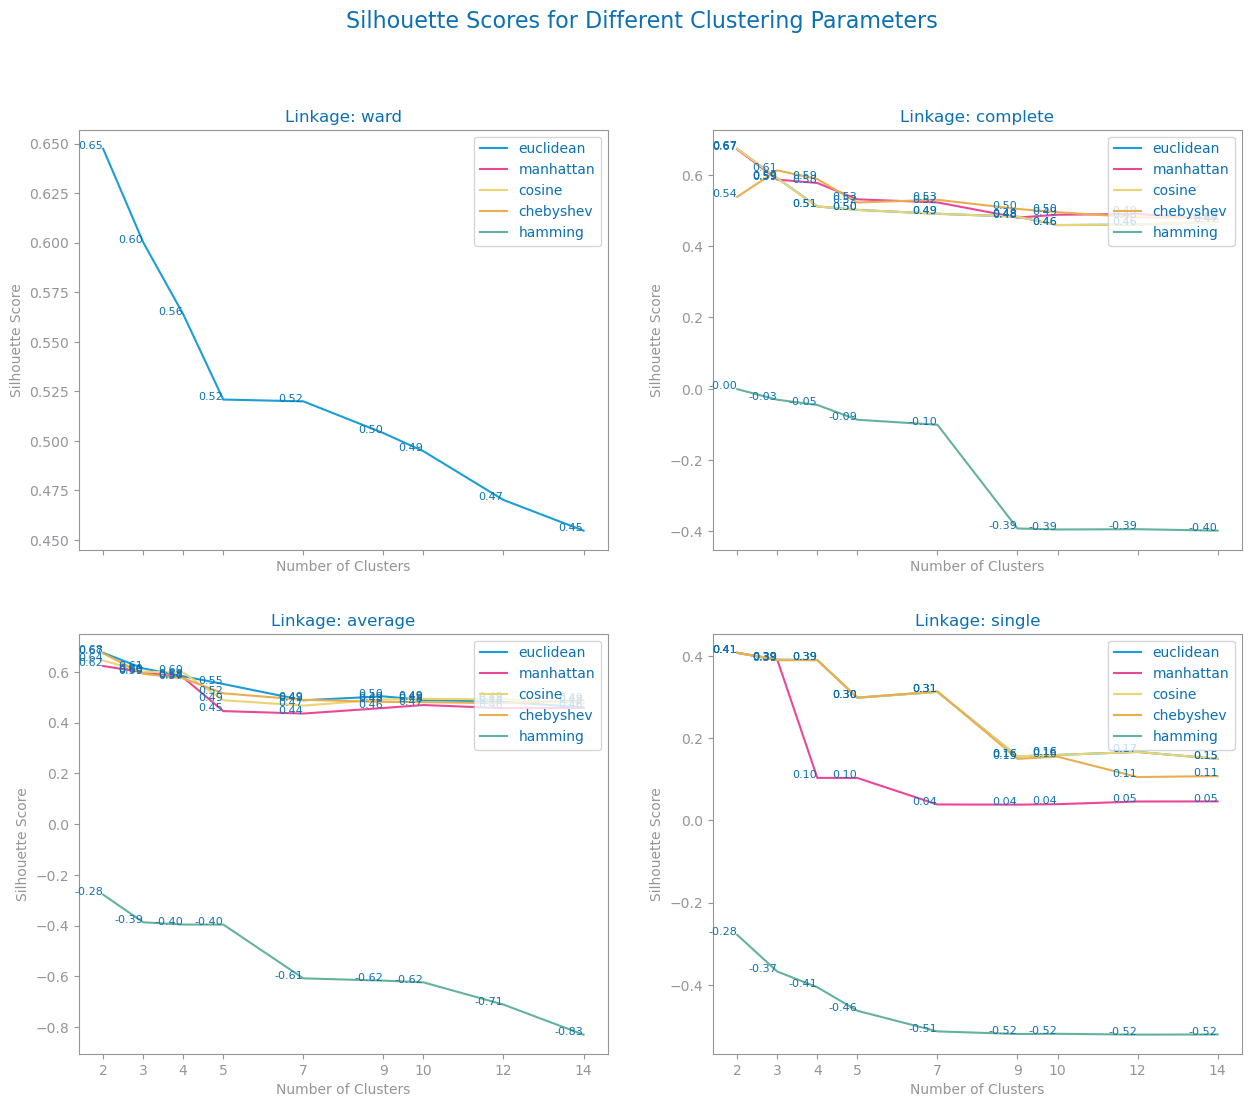

In [854]:
# available in data functions py
evaluate_agglomerative_clustering(data_scaled, n_clusters_list=[2, 3, 4, 5, 7, 9, 10, 12, 14], scale='no')

## 1. Dendrogram

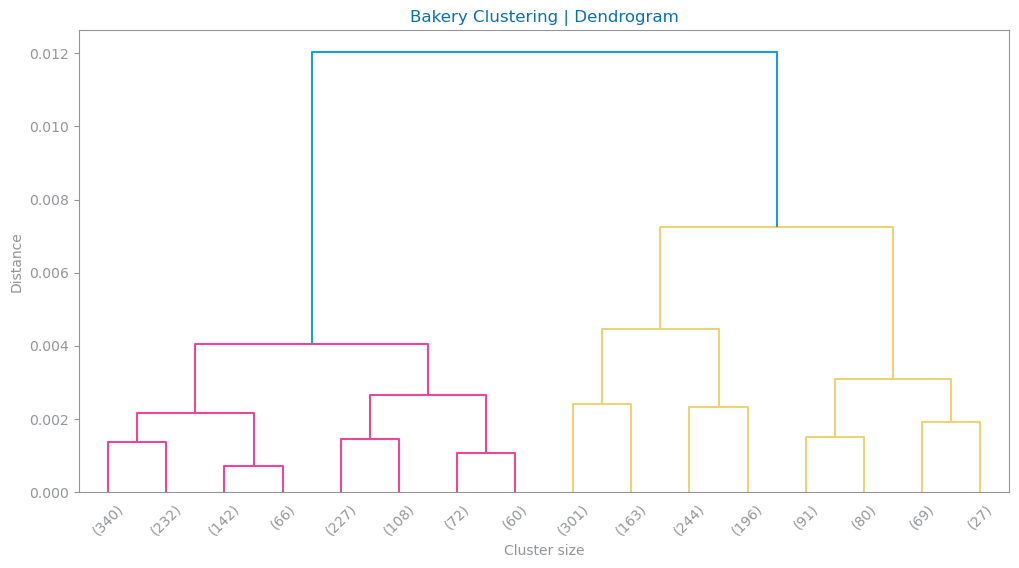

In [879]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

# Generate the linkage matrix
Z = linkage(data_scaled, method='average', metric='euclidean')

# Plot the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='level', p=3, leaf_rotation=45., leaf_font_size=10., count_sort='descending', distance_sort = 'ascending'), 
plt.title(f'{file_tag} | Dendrogram')
plt.xlabel('Cluster size')
plt.ylabel('Distance')
plt.show()


## 2. Agglomerative Model

In [856]:
bakery_aglo = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='average' )
bakery_y_pred_agglo = bakery_aglo.fit_predict(data_scaled)

bakery_y_pred_agglo

array([1, 0, 1, ..., 1, 1, 1])

## [prof] Evaluating the clustering solution using internal indices



In [880]:
from sklearn import metrics
#y_pred = kmeans_model.labels_
#print("Silhouette:",metrics.silhouette_score(data_scaled, y_pred))
#print("Silhouette per instance:\n",metrics.silhouette_samples(data_scaled, y_pred)[:5],"...")
#print("Sum of squared distances:",kmeans_model.inertia_)

print("Silhouette:", metrics.silhouette_score(data_scaled, bakery_y_pred_agglo))

print("Silhouette per instance:\n", metrics.silhouette_samples(data_scaled, bakery_y_pred_agglo)[:5], "...")



Silhouette: 0.6752079844792793
Silhouette per instance:
 [0.43449751 0.49612648 0.84305618 0.59988968 0.53147742] ...


# K MEANS clustering

## Elbow Method Study

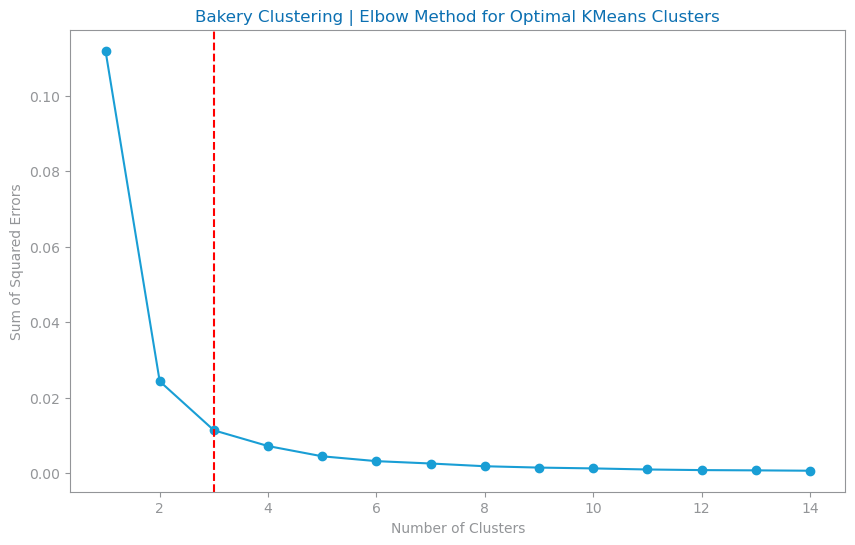

Optimal number of clusters (Elbow Method): 3


In [858]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from kneed import KneeLocator

# Define the range of clusters to evaluate
range_n_clusters = list(range(1, 15))

# Initialize an empty list to store the sum of squared distances
sse = []

# Loop over the range of clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(data_scaled)
    sse.append(kmeans.inertia_)

# Determine the elbow point using KneeLocator
kneedle = KneeLocator(range_n_clusters, sse, curve='convex', direction='decreasing')
elbow_point = kneedle.elbow

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, sse, marker='o')
plt.title(f'{file_tag} | Elbow Method for Optimal KMeans Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared Errors')

# Add a vertical line at the elbow point
plt.axvline(x=elbow_point, color='r', linestyle='--')

plt.show()

# Print the Optimal K After Elbow Method
print(f"Optimal number of clusters (Elbow Method): {elbow_point}")

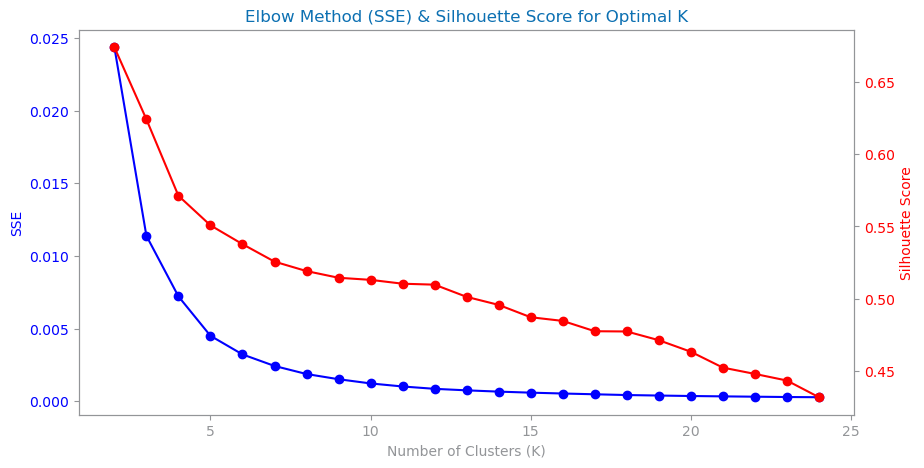

In [859]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

silhouette_scores = []
sse = []
K_range = range(2, 25)  # Testing K from 2 to 10

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(data_scaled)
    
    sse.append(kmeans.inertia_)  # Store SSE
    silhouette_scores.append(silhouette_score(data_scaled, labels))  # Store silhouette score

# Plot results
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot SSE (Elbow Method)
ax1.plot(K_range, sse, 'bo-', label="SSE (Inertia)", color='blue')
ax1.set_xlabel("Number of Clusters (K)")
ax1.set_ylabel("SSE", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot Silhouette Score
ax2 = ax1.twinx()
ax2.plot(K_range, silhouette_scores, 'ro-', label="Silhouette Score", color='red')
ax2.set_ylabel("Silhouette Score", color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.title("Elbow Method (SSE) & Silhouette Score for Optimal K")
plt.show()


## Kmeans model

In [860]:
# Clustering
from sklearn import cluster, mixture

# Starting from Scikit-learn 1.4, n_init='auto' is recommended for K-Means - it prevents future compatibility issues.

bakery_kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
bakery_y_pred_kmeans = bakery_kmeans.fit_predict(data_scaled)

bakery_kmeans.cluster_centers_

array([[ 9.99992250e-01,  6.24916773e-05,  2.30362184e-05,
         4.63820039e-06,  1.12517488e-05,  1.94546169e-05,
         3.91221656e-06,  1.97424233e-05,  8.00421070e-06,
         1.30389650e-05,  4.21669001e-06,  7.49797817e-06,
         1.18372785e-05,  7.84740854e-06,  4.78764267e-06,
         3.39845545e-03,  2.02508115e-05, -3.38496971e-05,
         4.50689936e-05,  8.57412903e-05,  1.00568746e-05,
         1.23352642e-05, -3.59218989e-05,  2.86008531e-05,
         2.74987659e-05, -1.58715000e-05,  4.66167734e-06,
         1.79867298e-06,  1.23791568e-06, -7.43237150e-08,
        -7.93521835e-06,  5.86382480e-06,  5.25731157e-06,
         5.20132183e-07],
       [ 9.99812247e-01,  6.39254125e-05,  2.04424420e-05,
         6.27653630e-06,  1.17693172e-05,  1.91708498e-05,
         6.05692186e-06,  1.86023281e-05,  8.55059282e-06,
         1.28563427e-05,  3.88792247e-06,  6.39123617e-06,
         1.00702132e-05,  1.02992118e-05,  4.29498026e-06,
         1.92141626e-02,  2.72

## Describe centroids


In [861]:

centroids = bakery_kmeans.cluster_centers_

feature_names = data_scaled.columns.tolist()

centroid_df = pd.DataFrame(data=centroids, columns=feature_names)
print("Cluster Centroids:")
print(centroid_df)

Cluster Centroids:
      total  angbutter  plain bread       jam  americano  croissant  \
0  0.999992   0.000062     0.000023  0.000005   0.000011   0.000019   
1  0.999812   0.000064     0.000020  0.000006   0.000012   0.000019   
2  0.999924   0.000065     0.000018  0.000005   0.000009   0.000022   

   caffe latte  tiramisu croissant  cacao deep  pain au chocolat  ...  \
0     0.000004            0.000020    0.000008          0.000013  ...   
1     0.000006            0.000019    0.000009          0.000013  ...   
2     0.000004            0.000017    0.000006          0.000017  ...   

   month_cos  hour_sin       min_sin   min_cos  day_of_month_sin  \
0   0.000027 -0.000016  4.661677e-06  0.000002          0.000001   
1   0.000018 -0.000020  6.809880e-07  0.000002         -0.000002   
2  -0.000026 -0.000012  5.188332e-06  0.000004         -0.000003   

   day_of_month_cos  day_of_week_nr_sin  day_of_week_nr_cos  \
0     -7.432372e-08           -0.000008            0.000006   
1   

In [862]:
# show the clusters per instance
cluster_labels = bakery_kmeans.labels_
print("Cluster Labels:")
print(cluster_labels)

Cluster Labels:
[2 2 0 ... 2 0 2]


## Sillhouete study for kmeans

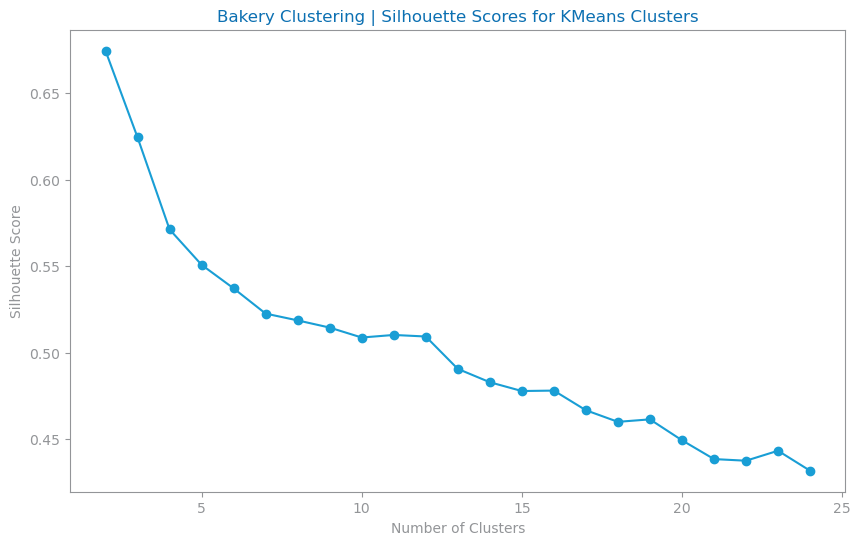

In [863]:
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt

# Define the range of clusters to evaluate
range_n_clusters = list(range(2, 25))

# Initialize an empty list to store the silhouette scores
silhouette_scores = []

# Loop over the range of clusters
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(data_scaled)
    silhouette_avg = silhouette_score(data_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title(f'{file_tag} | Silhouette Scores for KMeans Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [864]:
# Print the Best K After Silhouette Analysis

best_k = range_n_clusters[silhouette_scores.index(max(silhouette_scores))]
print(f"Optimal number of clusters (Silhouette Score): {best_k}")

Optimal number of clusters (Silhouette Score): 2


# [prof] Plotting clustering solutions



In [865]:
# Set up cluster parameters
# plt.figure(figsize=(7, 6))
# plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)
# color_array = ['#377eb8','#ff7f00','#4daf4a','#f781bf','#a65628','#984ea3','#999999','#e41a1c','#dede00']
# plot_num = 1
# for k in range(len(datasets)):
#     predictions = all_predictions[k]
#     efficiency = all_efficiency[k]
#     X, y = datasets[k][0]
#     X = StandardScaler().fit_transform(X)
#     
#     for name in predictions:
#         y_pred = predictions[name]
#         plt.subplot(len(datasets), len(algorithms), plot_num)
#         if k == 0: plt.title(name, size=10)
#         colors = np.array(list(islice(cycle(color_array),int(max(y_pred) + 1))))
#         colors = np.append(colors, ["#000000"]) #black color for outliers (if any)
#         
#         plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])
#         plt.xlim(-2.5, 2.5)
#         plt.ylim(-2.5, 2.5)
#         plt.xticks(())
#         plt.yticks(())
#         plt.text(.99, .01, ('%.2fs' % efficiency[name]).lstrip('0'),
#                  transform=plt.gca().transAxes,size=15,horizontalalignment='right')
#         plot_num += 1
# 
# plt.show()


# Others: spectral, agglomerative, dbscan, model-based
not done

# BOTH Model evaluation

In [866]:

from sklearn.metrics import silhouette_score, adjusted_rand_score


# Intrinsic Evaluation
silhouette_kmeans = silhouette_score(data_scaled, bakery_y_pred_kmeans)
silhouette_agglo = silhouette_score(data_scaled, bakery_y_pred_agglo)

print(f'Silhouette Score for KMeans: {silhouette_kmeans}')
print(f'Silhouette Score for Agglomerative Clustering: {silhouette_agglo}')



Silhouette Score for KMeans: 0.6245173060223771
Silhouette Score for Agglomerative Clustering: 0.6752079844792793


# Cluster Visualization

## Cluster Labeling

In [867]:
# Add cluster labels to the dataframe
data['kmeans_cluster'] = bakery_y_pred_kmeans
data['agglo_cluster'] = bakery_y_pred_agglo

# Display the dataframe with the new cluster labels
data.head()

,total,angbutter,plain bread,jam,americano,croissant,caffe latte,tiramisu croissant,cacao deep,pain au chocolat,...,min_sin,min_cos,day_of_month_sin,day_of_month_cos,day_of_week_nr_sin,day_of_week_nr_cos,week_of_month_sin,week_of_month_cos,kmeans_cluster,agglo_cluster
0,23800.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,...,-0.553,-0.833,0.791,-0.612,0.000,-1.0,0.0,-1.0,2,1
1,15800.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.875,0.485,0.791,-0.612,0.000,-1.0,0.0,-1.0,2,0
2,58000.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,...,-0.875,0.485,0.651,-0.759,-0.866,-0.5,0.0,-1.0,0,1
3,14800.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.899,-0.437,0.485,-0.874,-0.866,0.5,0.0,-1.0,2,0
4,15600.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.716,-0.698,0.485,-0.874,-0.866,0.5,0.0,-1.0,2,0


## Cluster Counts

In [868]:
# Group by kmeans_cluster and count the number of user IDs
kmeans_cluster_counts = data.groupby('kmeans_cluster').size()

# Group by agglo_cluster and count the number of user IDs
agglo_cluster_counts = data.groupby('agglo_cluster').size()

print("KMeans Cluster Counts:")
print(kmeans_cluster_counts)

print("\nAgglomerative Clustering Counts:")
print(agglo_cluster_counts)

KMeans Cluster Counts:
kmeans_cluster
0    1154
1     557
2     707
dtype: int64

Agglomerative Clustering Counts:
agglo_cluster
0    1171
1    1247
dtype: int64


## Cluster boxplots

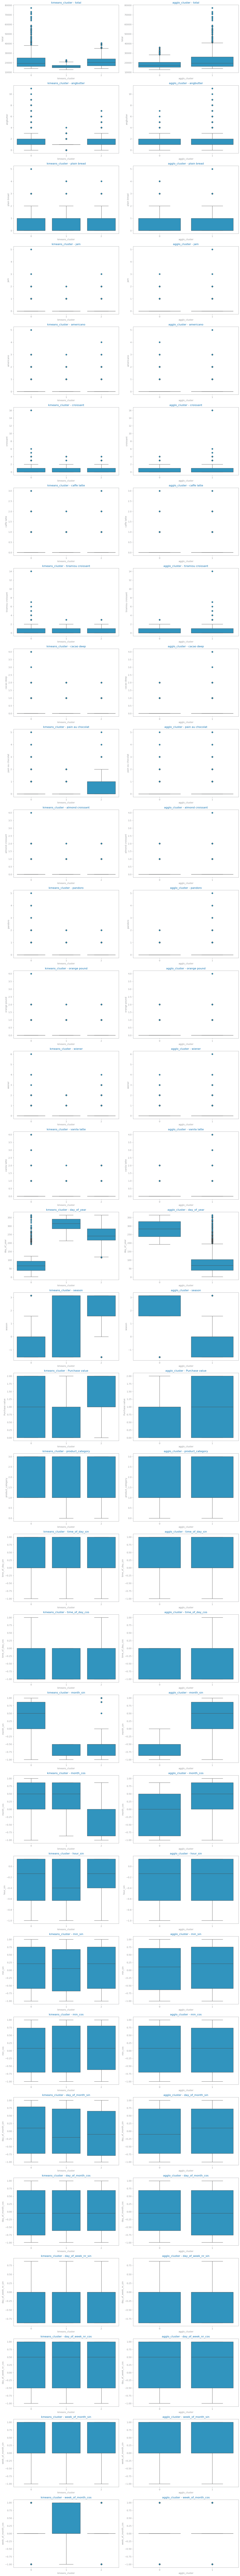

In [869]:
features = [col for col in numeric_vars if col in data.columns]

# Ensure 'cluster_labels' only includes columns present in the updated 'data'
cluster_labels = [col for col in ['kmeans_cluster', 'agglo_cluster'] if col in data.columns]

plot_cluster_boxplots(data, features, cluster_labels)


## 1. Cluster Centroids Heatmap (For Feature Importance)
Another way to analyze clustering is by visualizing the centroid values for each feature.
Helps interpret which features are important for each cluster: which are the mean values of each feature for each cluster.
- The values in each cell represent the mean normalized value of the feature for that cluster.
- Since the data is normalized row-wise, the values indicate the relative importance of each feature within the cluster.
- values close to 0 - not important
- values close to 1 - the feature is very important for defining the cluster.


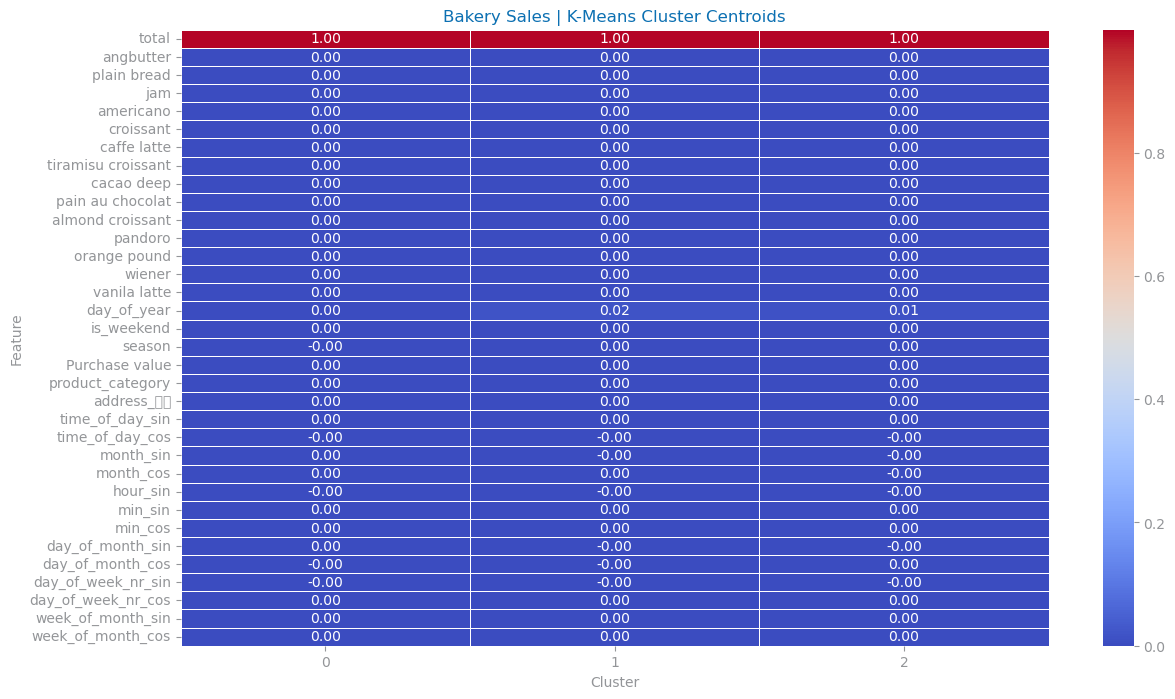

In [870]:
import seaborn as sns
import pandas as pd

# Create a dataframe of centroids
centroids = pd.DataFrame(bakery_kmeans.cluster_centers_, columns=data_scaled.columns)

# Plot a heatmap of feature values for each cluster
plt.figure(figsize=(14, 8))
sns.heatmap(centroids.T, cmap="coolwarm", annot=True, fmt=".2f", linewidths=0.5)
plt.title("Bakery Sales | K-Means Cluster Centroids")
plt.xlabel("Cluster")
plt.ylabel("Feature")
plt.show()


## t-SNE 
- PCA might not be the best for clustering visualization if the structure is non-linear.
- t-SNE and UMAP are better at preserving local cluster structures.
- t-SNE doesn’t have a direct equivalent to PCA’s total explained variance because it is a nonlinear dimensionality reduction technique that focuses on preserving local structure rather than maximizing variance.

[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 2418 samples in 0.000s...
[t-SNE] Computed neighbors for 2418 samples in 0.036s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2418
[t-SNE] Computed conditional probabilities for sample 2000 / 2418
[t-SNE] Computed conditional probabilities for sample 2418 / 2418
[t-SNE] Mean sigma: 0.000090
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.347252
[t-SNE] KL divergence after 1000 iterations: 0.722054


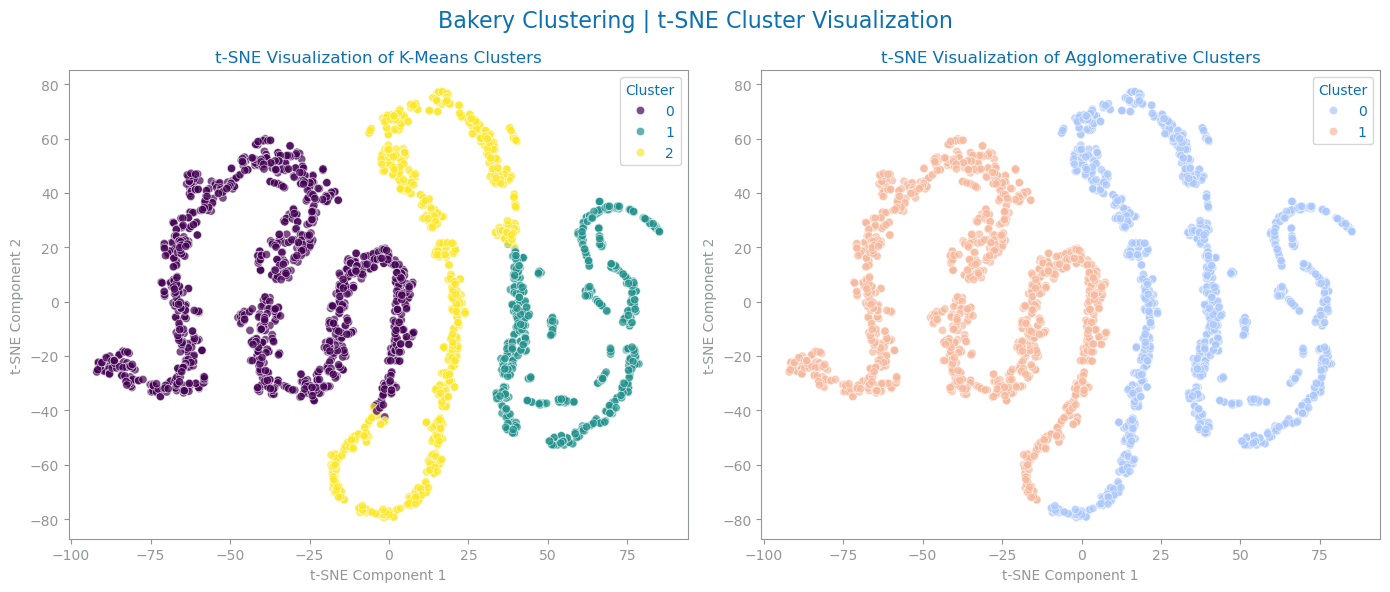

In [890]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# Assuming you already have the t-SNE embeddings for both models
tsne = TSNE(n_components=2, perplexity=10, random_state=42, verbose=1)
tsne_results = tsne.fit_transform(data_scaled)  

# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# K-Means Plot
sns.scatterplot(
    x=tsne_results[:, 0], y=tsne_results[:, 1], 
    hue=data['kmeans_cluster'], palette="viridis", alpha=0.7, ax=axes[0]
)
axes[0].set_title("t-SNE Visualization of K-Means Clusters")

# Agglomerative Clustering Plot
sns.scatterplot(
    x=tsne_results[:, 0], y=tsne_results[:, 1], 
    hue=data['agglo_cluster'], palette="coolwarm", alpha=0.7, ax=axes[1]
)
axes[1].set_title("t-SNE Visualization of Agglomerative Clusters")

# General plot settings
for ax in axes:
    ax.set_xlabel("t-SNE Component 1")
    ax.set_ylabel("t-SNE Component 2")
    ax.legend(title="Cluster")

plt.suptitle(f"{file_tag} | t-SNE Cluster Visualization", fontsize=16)
plt.tight_layout()
plt.show()


## 2. PCA visualization

In [882]:
from sklearn.decomposition import PCA

# Visualization
pca = PCA(n_components=3) #tentar fazer com mais componentes
bakery_pca = pca.fit_transform(data_scaled)

pca_bakery_df = pd.DataFrame(bakery_pca, columns=[f'PC{i+1}' for i in range(bakery_pca.shape[1])])
pca_bakery_df.head()

,PC1,PC2,PC3
0,-0.001535,-0.000052,0.000051
1,0.002550,-0.000060,-0.000013
2,-0.006274,-0.000055,-0.000042
3,0.003506,-0.000041,0.000127
4,0.002834,-0.000059,-0.000017


### PCA  explained variance ratio

In [883]:
# Fit the PCA model
pca.fit(data_scaled)

# Explained variance ratio
explained_variance_bakery = pca.explained_variance_ratio_
total_variance_explained = explained_variance_bakery.sum()

print(f'Explained variance ratio: {explained_variance_bakery}')
print(f'Total Explained variance ratio: {total_variance_explained}')



Explained variance ratio: [9.9918887e-01 1.7273420e-04 7.7801836e-05]
Total Explained variance ratio: 0.9994394064303977


### 2D PCA Plot

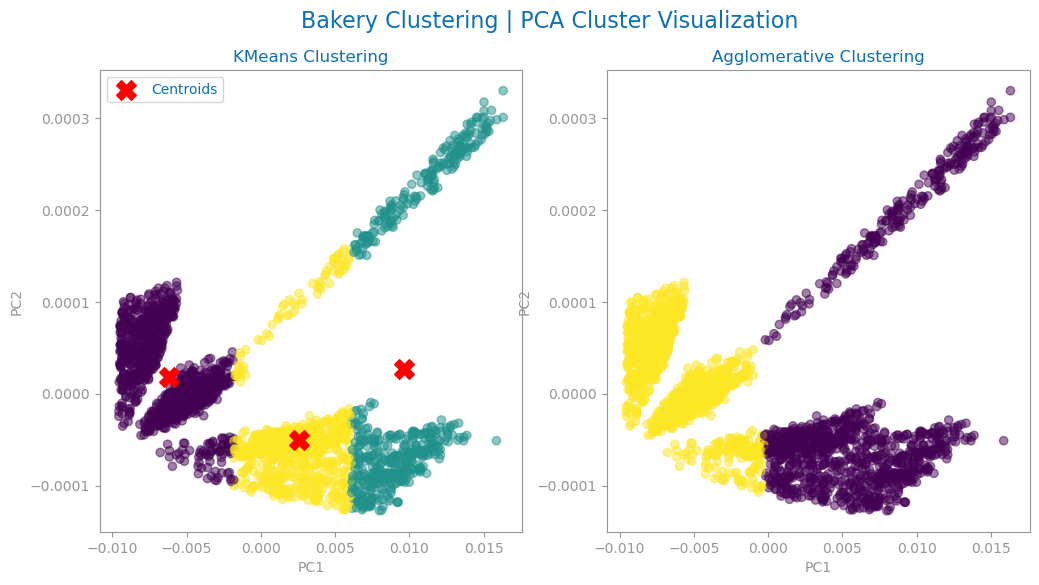

In [884]:
plt.figure(figsize=(12, 6))

# KMeans Clustering
plt.subplot(121)
plt.scatter(pca_bakery_df['PC1'], pca_bakery_df['PC2'], c=bakery_y_pred_kmeans, cmap='viridis', alpha=0.5)
kmeans_centroids = pca.transform(bakery_kmeans.cluster_centers_)
plt.scatter(kmeans_centroids[:, 0], kmeans_centroids[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('KMeans Clustering')
plt.legend()

# Agglomerative Clustering
plt.subplot(122)
plt.scatter(pca_bakery_df['PC1'], pca_bakery_df['PC2'], c=bakery_y_pred_agglo, cmap='viridis', alpha=0.5)
# Agglomerative clustering does not have centroids, so we skip this part
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Agglomerative Clustering')

plt.suptitle(f"{file_tag} | PCA Cluster Visualization", fontsize=16)

plt.show()

### 3D PCA Plot

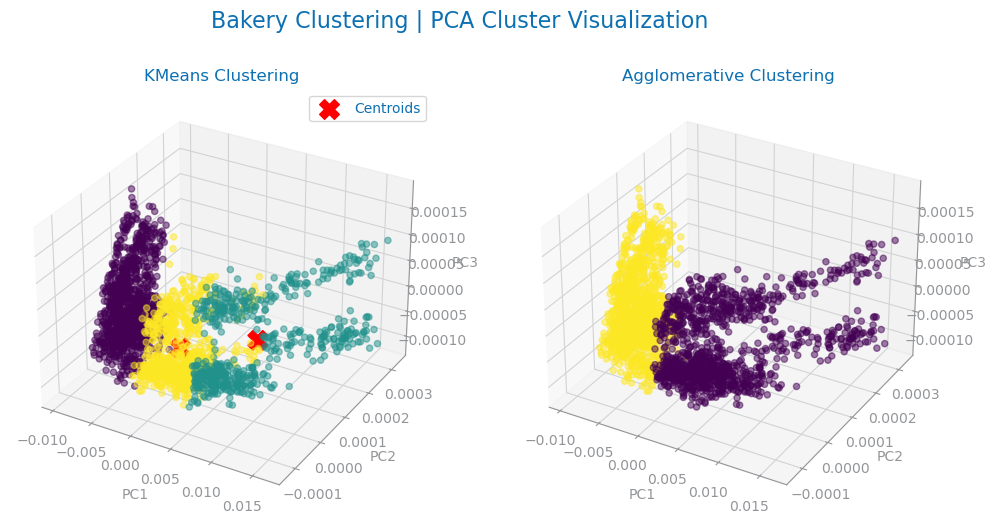

In [885]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 6))

# KMeans Clustering
ax = fig.add_subplot(121, projection='3d')
ax.scatter(pca_bakery_df['PC1'], pca_bakery_df['PC2'], pca_bakery_df['PC3'], c=bakery_y_pred_kmeans, cmap='viridis', alpha=0.5)
kmeans_centroids_3d = pca.transform(bakery_kmeans.cluster_centers_)
ax.scatter(kmeans_centroids_3d[:, 0], kmeans_centroids_3d[:, 1], kmeans_centroids_3d[:, 2], c='red', marker='X', s=200, label='Centroids')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('KMeans Clustering')
ax.legend()

# Agglomerative Clustering
ax = fig.add_subplot(122, projection='3d')
ax.scatter(pca_bakery_df['PC1'], pca_bakery_df['PC2'], pca_bakery_df['PC3'], c=bakery_y_pred_agglo, cmap='viridis', alpha=0.5)
# Agglomerative clustering does not have centroids, so we skip this part
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Agglomerative Clustering')

fig.suptitle(f"{file_tag} | PCA Cluster Visualization", fontsize=16)

plt.show()

# test: silhouete of diff scaling methods

In [886]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer
import pandas as pd

# Assuming 'data' is your original DataFrame
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler(),
    'Normalizer': Normalizer()
}

scaled_data = {}
for name, scaler in scalers.items():
    scaled_data[name] = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

In [887]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

results = {}

for name, scaled_df in scaled_data.items():
    # K-means Clustering
    kmeans = KMeans(n_clusters=5, random_state=42, n_init='auto')
    kmeans_labels = kmeans.fit_predict(scaled_df)
    kmeans_score = silhouette_score(scaled_df, kmeans_labels)

    # Agglomerative Clustering
    agglo = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='single')
    agglo_labels = agglo.fit_predict(scaled_df)
    agglo_score = silhouette_score(scaled_df, agglo_labels)

    results[name] = {
        'KMeans Silhouette Score': kmeans_score,
        'Agglomerative Silhouette Score': agglo_score
    }

# Print results
for scaler, scores in results.items():
    print(f"Scaler: {scaler}")
    print(f"  KMeans Silhouette Score: {scores['KMeans Silhouette Score']}")
    print(f"  Agglomerative Silhouette Score: {scores['Agglomerative Silhouette Score']}")
    print()

Scaler: StandardScaler
  KMeans Silhouette Score: 0.0726438267957498
  Agglomerative Silhouette Score: 0.4890843609130854

Scaler: MinMaxScaler
  KMeans Silhouette Score: 0.12455845099033604
  Agglomerative Silhouette Score: 0.055864893410707016

Scaler: RobustScaler
  KMeans Silhouette Score: 0.06444662146255675
  Agglomerative Silhouette Score: 0.6103373615944284

Scaler: Normalizer
  KMeans Silhouette Score: 0.5506861001362974
  Agglomerative Silhouette Score: 0.38981305094144403



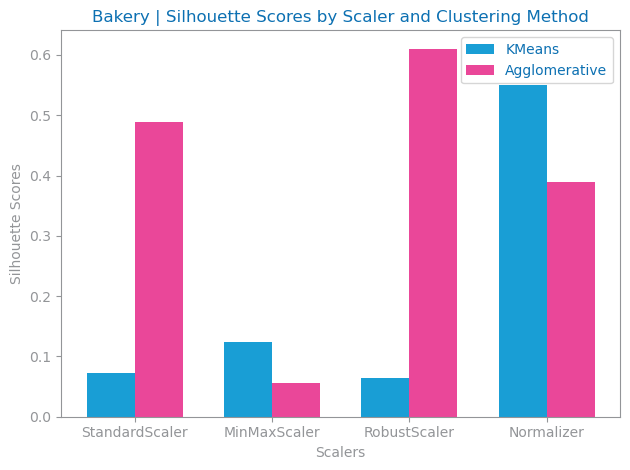

In [888]:
import matplotlib.pyplot as plt
import numpy as np

scaler_names = list(results.keys())
kmeans_scores = [results[scaler]['KMeans Silhouette Score'] for scaler in scaler_names]
agglo_scores = [results[scaler]['Agglomerative Silhouette Score'] for scaler in scaler_names]

x = np.arange(len(scaler_names))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, kmeans_scores, width, label='KMeans')
rects2 = ax.bar(x + width/2, agglo_scores, width, label='Agglomerative')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Scalers')
ax.set_ylabel('Silhouette Scores')
ax.set_title('Bakery | Silhouette Scores by Scaler and Clustering Method')
ax.set_xticks(x)
ax.set_xticklabels(scaler_names)
ax.legend()

fig.tight_layout()

plt.show()